# Temperature - precipitation scaling 

Investigating changes of extreme precipitation with increases in temperature and moisture. 


In [1]:
import numpy as np 
import xarray as xr 
import atmotrans as atm
import matplotlib.pyplot as plt 

In [2]:
#WRF 
wrf= xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/wrf_mean_q_pressure_1989-1999.nc')
wrf_q= wrf.mixr[0]
wrf_pressure = wrf.pressure.values
wrf= xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/wrf_mean_q_pressure_2000-2017.nc')
wrf_q_recent= wrf.mixr[0]


# ERA 
era = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/cache/pressure-monthly/era5_mean_q_1980-1999.nc')
era_q= era.q[0]
era_pressure = era.level.values
era = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/cache/pressure-monthly/era5_mean_q_2000-2017.nc')
era_q_recent= era.q[0]
# surface pressure for column-integration 
era_sp= xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/cache/srfc-monthly/sfrc_pressure_1980-1999.nc').sp[0]/100
era_sp_recent = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/cache/srfc-monthly/sfrc_pressure_2000-2017.nc').sp[0]/100

## Changes in total integrated column water vapour ERA5 vs. WRF9km 

In [19]:
era_tcwv_diff = atm.column_integration(era_pressure, (era_sp.values+era_sp_recent.values)/2, era_q_recent.values - era_q.values)

era_tcwv_recent = atm.column_integration(era_pressure, era_sp_recent.values ,era_q_recent.values )
era_tcwv= atm.column_integration(era_pressure, era_sp.values,  era_q.values)


## Binning 

- Attribute each hourly precipitation value of wet events to daily surface temperature bin of 2C bin width (temperature should represent air mass and should therefoe not be on a too short time scale)
- calculate percentiles for each bin size 

In [2]:
keys =  np.arange(-30,40,2).astype(str)
keys = list(map('b'.__add__,keys))
bins = dict.fromkeys(keys, np.array(()))
bins_con = dict.fromkeys(keys, np.array(()))
bins_div = dict.fromkeys(keys, np.array(()))
bins_tp = dict.fromkeys(keys, np.array(()))

In [3]:
testdata = xr.open_dataset('/media/juli/Data/projects/data/ERA5/ERA5_2002-07_PT_GlHrly.nc')

# extract domain and fix unit (from m to mm per hour)                                                                                                  
lc= testdata.coords["longitude"]
la= testdata.coords["latitude"]
precip_tp= testdata.tp.loc[dict(longitude=lc[(lc > 50) & (lc < 135)], latitude=la[(la > 10) & (la < 60)])] * 1000
temp_tp= testdata.t2m.loc[dict(longitude=lc[(lc > 50) & (lc < 135)], latitude=la[(la > 10) & (la < 60)])] - 273.15


In [4]:
# apply additional regional selections 
vimd = xr.open_dataset('../moisture_transport/moisture_transport/cache/era5_monthlymean_clim_moistdiv.nc').vimd[0]


In [6]:
# loop through days in month 
for d in np.arange(1,31):
    # get mean daily surface temperature
    daily_temp = temp_tp.sel(time= (temp_tp['time.day'] == 10) ).mean(dim='time')
    wet_hours = precip_tp.where(precip_tp > 0.1)
    for i in np.arange(-30,40,2):
        ii = i+2
        bin_values=wet_hours.where( (daily_temp >= i)  &  (daily_temp <= ii)    ).data
        values = bin_values[~np.isnan(bin_values)]

        # attribute to bin
        bins['b' + str(i)] = np.append(bins['b' + str(i)], values)
        
        # convergence zone
        bin_values = wet_hours.where( (daily_temp >= i)  &  (daily_temp <= ii)  )
        convergence  = bin_values.where(-vimd > 0 ).data
        values = convergence[~np.isnan(convergence)]
        bins_con['b' + str(i)] = np.append(bins_con['b' + str(i)], values)
        
        # divergence zone
        divergence  = bin_values.where(-vimd < 0 ).data
        values = divergence[~np.isnan(divergence)]
        bins_div['b' + str(i)] = np.append(bins_div['b' + str(i)], values)

In [7]:
# save distributions 

xbins = xr.Dataset(bins)
xbins.to_netcdf('cc_bins_2002.nc') 

xbins = xr.Dataset(bins_con)
xbins.to_netcdf('cc_bins_con_2002.nc')

xbins = xr.Dataset(bins_div)
xbins.to_netcdf('cc_bins_div_2002.nc')

In [315]:
percentiles99 = np.zeros((len(bins.keys())))
percentiles95 = np.zeros((len(bins.keys())))
percentiles90 = np.zeros((len(bins.keys())))

for idx,i in enumerate(np.arange(-30,40,2)): 
    if bins_con[i].size > 0:
        percentiles99[idx] = np.percentile(bins_con[i], 99 ) 
        percentiles95[idx] =  np.percentile(bins_con[i], 95 ) 
        percentiles90[idx] = np.percentile(bins_con[i], 90 ) 

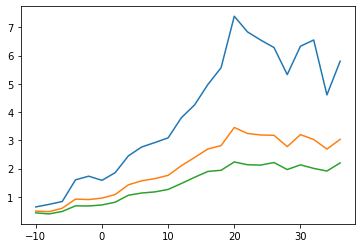

In [316]:
plt.plot(np.arange(-10,38,2), percentiles99[10:-1])
plt.plot(np.arange(-10,38,2), percentiles95[10:-1])
plt.plot(np.arange(-10,38,2), percentiles90[10:-1])

#plt.plot(np.arange(-11,38,2), cc(25, percentiles90[0]))
plt.show()

In [317]:
percentiles99 = np.zeros((len(bins.keys())))
percentiles95 = np.zeros((len(bins.keys())))
percentiles90 = np.zeros((len(bins.keys())))

for idx,i in enumerate(np.arange(-30,40,2)): 
    if bins_div[i].size > 0:
        percentiles99[idx] = np.percentile(bins_div[i], 99 ) 
        percentiles95[idx] =  np.percentile(bins_div[i], 95 ) 
        percentiles90[idx] = np.percentile(bins_div[i], 90 )  

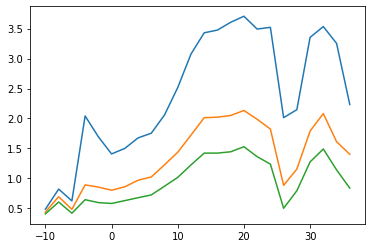

In [318]:
plt.plot(np.arange(-10,38,2), percentiles99[10:-1])
plt.plot(np.arange(-10,38,2), percentiles95[10:-1])
plt.plot(np.arange(-10,38,2), percentiles90[10:-1])
#plt.plot(np.arange(-11,38,2), cc(25, percentiles90[0]))
plt.show()

In [215]:
def cc(iterations, start):
    values = [start]
    for e in np.arange(iterations):
        val= values[-1]
        values.append(val + 0.07*val)
    
    return values 

## Calculate scaling rates for each grid point 